<a href="https://www.kaggle.com/code/karahanos/pre-snap-game-prediction?scriptVersionId=202645564" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

 ## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from xgboost import XGBClassifier
from sklearn.datasets import make_classification 
import xgboost as xgb

# Function to drop unwanted features from the dataset
def drop_unwanted_features(df, features_to_drop):
    """
    Drops specified features (columns) from the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    features_to_drop (list): List of column names to drop.
    
    Returns:
    pd.DataFrame: A new DataFrame with the specified columns dropped.
    """
    # Check if all columns to drop exist in the DataFrame
    features_to_drop = [feature for feature in features_to_drop if feature in df.columns]
    
    # Drop the unwanted features
    df_cleaned = df.drop(columns=features_to_drop)
    
    return df_cleaned
    # Returns a DataFrame without the unwanted columns

# Function to convert game clock time into seconds
def convert_to_seconds(game_clock):
    """
    Converts the game clock time (in 'MM:SS' format) to seconds.
    
    Parameters:
    game_clock (str): The game clock time as a string in 'MM:SS' format.
    
    Returns:
    int: The game clock time converted into seconds.
    """
    # Split the clock string into minutes and seconds and convert to integers
    minutes, seconds = map(int, game_clock.split(':'))
    
    # Convert the time into total seconds
    return minutes * 60 + seconds

# Function to calculate remaining time till the end of the half
def calculate_remaining_time_end_of_half(row):
    """
    Calculates the remaining time in seconds until the end of the half based on the game clock and half number.
    
    Parameters:
    row (pd.Series): A row of the DataFrame containing 'gameClock' and 'half' columns.
    
    Returns:
    int: The remaining time in seconds until the end of the half.
    """
    half_game_time = 30 * 60  # 1800 seconds in a half (30 minutes * 60 seconds)
    
    # Convert the game clock to seconds for the current row
    quarter_time_remaining = convert_to_seconds(row['gameClock'])
    
    # Calculate the total elapsed time in the game up to the current quarter
    # Half 1 includes the first two quarters (each 15 minutes or 900 seconds), so we account for that
    elapsed_time = (row['half'] - 1) * 900 + (900 - quarter_time_remaining)
    
    # Remaining time until the end of the half
    return half_game_time - elapsed_time


### Initial Data Understanding and Cleaning

In [2]:
plays_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2025/plays.csv')
games_df = pd.read_csv(r'/kaggle/input/nfl-big-data-bowl-2025/games.csv')


In [3]:
plays_df.sample(5)

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
9646,2022100904,3532,(2:45) (Shotgun) K.Cousins pass short left to ...,4,3,8,MIN,CHI,CHI,13,...,11,0.129294,-0.129294,2.593053,True,NaN,NaN,0,Cover-2,Zone
13126,2022110608,1767,"(1:44) (No Huddle, Shotgun) K.Murray scrambles...",2,2,7,ARI,SEA,ARI,26,...,17,0.047671,-0.047671,1.178906,True,NaN,NaN,0,Cover-6 Right,Zone
1321,2022101604,3502,(6:08) (Shotgun) T.Bridgewater pass short righ...,4,4,5,MIA,MIN,MIA,48,...,14,0.112978,-0.112978,3.738037,True,NaN,NaN,0,Cover-1 Double,Man
15313,2022103100,853,(14:54) K.Hunt left tackle to CLV 22 for 9 yar...,2,1,10,CLE,CIN,CLE,13,...,9,0.025722,-0.025722,0.655930,False,OUTSIDE ZONE,NaN,0,Cover-1,Man
4500,2022110610,2792,(3:34) (Shotgun) M.Willis pass short right to ...,3,3,14,TEN,KC,TEN,33,...,2,0.048917,-0.048917,-1.126069,True,NaN,NaN,0,Cover 6-Left,Zone


As we see this dataframe contains various data about plays as descriptive, post-snap or pre-snap. Since we investigate a pre-snap incident we could drop irrelevant features like playDescription.   

In [4]:
plays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16124 entries, 0 to 16123
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gameId                            16124 non-null  int64  
 1   playId                            16124 non-null  int64  
 2   playDescription                   16124 non-null  object 
 3   quarter                           16124 non-null  int64  
 4   down                              16124 non-null  int64  
 5   yardsToGo                         16124 non-null  int64  
 6   possessionTeam                    16124 non-null  object 
 7   defensiveTeam                     16124 non-null  object 
 8   yardlineSide                      15900 non-null  object 
 9   yardlineNumber                    16124 non-null  int64  
 10  gameClock                         16124 non-null  object 
 11  preSnapHomeScore                  16124 non-null  int64  
 12  preS

In [5]:
games_df.sample(5)

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
16,2022091500,2022,2,9/15/2022,20:15:00,KC,LAC,27,24
130,2022110606,2022,9,11/6/2022,13:00:00,NYJ,BUF,20,17
126,2022110602,2022,9,11/6/2022,13:00:00,CIN,CAR,42,21
112,2022103003,2022,8,10/30/2022,13:00:00,DET,MIA,27,31
25,2022091808,2022,2,9/18/2022,16:05:00,SF,SEA,27,7


In [6]:
plays_df.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
       'pff_pass

In [7]:
games_df.columns

Index(['gameId', 'season', 'week', 'gameDate', 'gameTimeEastern',
       'homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore',
       'visitorFinalScore'],
      dtype='object')

In [8]:
df = plays_df.merge(games_df[['gameId','homeTeamAbbr', 'visitorTeamAbbr']], on='gameId', how='left')
# Merged two data set on gameIds

I've merged the two data-set cause I will use it to create a feature that called possessionTeamScore and defensiveTeamScore.

In [9]:
df.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
       'pff_pass

In [10]:
features_to_drop = ['gameId','playId','isDropback', 'expectedPointsAdded', 'yardsGained', 'visitorTeamWinProbilityAdded',
                    'homeTeamWinProbabilityAdded','prePenaltyYardsGained','penaltyYards','rushLocationType','qbSneak',
                    'qbKneel','qbSpike','unblockedPressure','passTippedAtLine','timeToSack','timeInTackleBox','timeToThrow',
                    'passLocationType','dropbackDistance','dropbackType','playAction','targetX', 'targetY','passLength',
                    'playClockAtSnap', 'expectedPoints','preSnapVisitorTeamWinProbability','preSnapHomeTeamWinProbability',
                    'playNullifiedByPenalty','yardlineSide','yardlineNumber','playDescription','pff_manZone','pff_passCoverage',
                    'pff_runPassOption','pff_runConceptSecondary','pff_runConceptPrimary']
 

In here I've droped unnecessary columns for prediction

In [11]:
df_cleaned = drop_unwanted_features(df,features_to_drop)


In [12]:
df_cleaned.sample(5)

,quarter,down,yardsToGo,possessionTeam,defensiveTeam,gameClock,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,offenseFormation,receiverAlignment,passResult,homeTeamAbbr,visitorTeamAbbr
8261,1,2,4,NO,ARI,14:28,0,0,79,SINGLEBACK,2x2,NaN,ARI,NO
7316,1,1,10,CAR,TB,12:45,0,0,100,SHOTGUN,2x2,I,CAR,TB
14350,4,3,3,MIA,PIT,02:41,16,10,52,SINGLEBACK,3x1,I,MIA,PIT
13981,2,1,10,BUF,PIT,07:24,17,3,95,SHOTGUN,2x2,C,BUF,PIT
15141,2,3,1,PHI,JAX,05:48,7,14,39,JUMBO,3x1,NaN,PHI,JAX


In [13]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16124 entries, 0 to 16123
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   quarter                 16124 non-null  int64 
 1   down                    16124 non-null  int64 
 2   yardsToGo               16124 non-null  int64 
 3   possessionTeam          16124 non-null  object
 4   defensiveTeam           16124 non-null  object
 5   gameClock               16124 non-null  object
 6   preSnapHomeScore        16124 non-null  int64 
 7   preSnapVisitorScore     16124 non-null  int64 
 8   absoluteYardlineNumber  16124 non-null  int64 
 9   offenseFormation        15936 non-null  object
 10  receiverAlignment       15936 non-null  object
 11  passResult              9736 non-null   object
 12  homeTeamAbbr            16124 non-null  object
 13  visitorTeamAbbr         16124 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


## Feature Creation

I have tried to create my features in scope of situational football:
- Is my team behind? I would tend to play because I would tie the game asap.
- Is my team needs to hurry for a TD because we are behind and run out of time?
- Are we leading and inside last two mins? I would tend to run the ball because I gotta melt time.  

In [14]:
# Half feature created 
df_cleaned['half'] = df_cleaned['quarter'].apply(lambda row: 1 if row < 3 else 2)

In [15]:
# # Remaing time feature created
df_cleaned.loc[:, 'remainingTime'] = df_cleaned.apply(calculate_remaining_time_end_of_half, axis=1)


In [16]:
# df_cleaned dataset score data store as preSnapHomeScore and preSnapVisitor but team stored as possesionTeam and defensiveTeam.

df_cleaned['possessionTeamScore'] = df_cleaned.apply(lambda row: row['preSnapHomeScore'] if row['possessionTeam'] == row['homeTeamAbbr'] else row['preSnapVisitorScore'], axis=1)
 
df_cleaned['defensiveTeamScore'] = df_cleaned.apply(lambda row: row['preSnapVisitorScore'] if row['possessionTeam'] == row['homeTeamAbbr'] else row['preSnapHomeScore'], axis=1)

# So I converted preSnapHomeScore and preSnapVisitor data to possessionTeamScore and defensiveTeamScore.

In [17]:
# This feature shows how many yards left for TD
df_cleaned['yardsToTd'] = df_cleaned['absoluteYardlineNumber'] - 10

In [18]:
# This feature creates a score difference and shows that possesion team leading or not.
df_cleaned['possessionTeamLeadsBy'] = df_cleaned['possessionTeamScore'] - df_cleaned['defensiveTeamScore']


In [19]:
df_cleaned['isPossessionTeamLead'] = df_cleaned.apply(lambda row: 0 if row['possessionTeamLeadsBy'] > 0 else 1, axis=1 )

In [20]:
df_cleaned['isPossessionTeamLead'] = df_cleaned['isPossessionTeamLead'].astype('byte')

In [21]:
# Get the list of column names
new_order = ['half','quarter', 'gameClock','remainingTime', 'down', 'yardsToGo', 'yardsToTd','possessionTeamLeadsBy','isPossessionTeamLead',
             'possessionTeam', 'defensiveTeam','homeTeamAbbr', 'visitorTeamAbbr','possessionTeamScore', 'defensiveTeamScore',
             'preSnapHomeScore','preSnapVisitorScore', 'absoluteYardlineNumber', 'offenseFormation', 'receiverAlignment', 'passResult']

# Reorder the columns in the DataFrame
df_cleaned = df_cleaned[new_order]

# Check the reordered DataFrame
print(df_cleaned.head())


   half  quarter gameClock  remainingTime  down  yardsToGo  yardsToTd  \
0     2        3     01:54            114     1         10         21   
1     2        4     02:13            133     1         10          8   
2     2        4     02:00            120     3         12         20   
3     1        1     09:28           1468     2         10         23   
4     2        3     02:16            136     2          8         27   

   possessionTeamLeadsBy  isPossessionTeamLead possessionTeam  ...  \
0                     18                     0            CIN  ...   
1                      0                     1            CIN  ...   
2                    -14                     1            HOU  ...   
3                      0                     1             KC  ...   
4                      0                     1            BAL  ...   

  homeTeamAbbr visitorTeamAbbr possessionTeamScore  defensiveTeamScore  \
0          CIN             ATL                  35                

In [22]:
df_cleaned['offenseFormation'].value_counts()

offenseFormation
SHOTGUN       8791
SINGLEBACK    3915
EMPTY         1342
I_FORM        1035
PISTOL         641
JUMBO          125
WILDCAT         87
Name: count, dtype: int64

As we know some formations have tendencies for pass or run games.

In [23]:
df_cleaned = df_cleaned.copy()  # Create a deep copy of the DataFrame
heavyPass = ['SHOTGUN', 'EMPTY']
df_cleaned['isHeavyRun/Pass'] = df_cleaned['offenseFormation'].apply(lambda formation: 1 if formation in heavyPass else 0)
df_cleaned['isHeavyRun/Pass'] = df_cleaned['isHeavyRun/Pass'].astype('byte')


In [24]:
df_cleaned['receiverAlignment'].value_counts()

receiverAlignment
2x2    6483
3x1    6044
2x1    1824
3x2    1232
1x1     160
4x1     129
2x0      45
3x0       9
1x0       8
4x2       1
3x3       1
Name: count, dtype: int64

In [25]:
heavyRun = ['1x0', '2x0', '3x0', '1x1', '2x1']
df_cleaned.loc[:, 'isWRsHeavyRun/Pass'] = df_cleaned['receiverAlignment'].apply(lambda alignment: 0 if alignment in heavyRun else 1)
df_cleaned['isWRsHeavyRun/Pass'] = df_cleaned['isWRsHeavyRun/Pass'].astype('byte')

In [26]:
# This feature is bytes variable that show the game wheter game is pass (1) or not (0)
df_cleaned['WasItPass'] = df_cleaned['passResult'].apply(lambda row: 0 if pd.isnull(row) == True else 1)

In [27]:
df_cleaned.sample(5)

,half,quarter,gameClock,remainingTime,down,yardsToGo,yardsToTd,possessionTeamLeadsBy,isPossessionTeamLead,possessionTeam,...,defensiveTeamScore,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,offenseFormation,receiverAlignment,passResult,isHeavyRun/Pass,isWRsHeavyRun/Pass,WasItPass
577,2,3,12:42,762,3,10,17,-8,1,SF,...,21,13,21,27,SHOTGUN,3x1,C,1,1,1
10485,2,4,01:18,78,4,9,9,-8,1,LV,...,24,24,16,19,SHOTGUN,3x1,C,1,1,1
4814,2,3,04:02,242,2,7,33,2,0,DET,...,6,8,6,43,SINGLEBACK,2x2,NaN,0,1,0
9941,2,4,13:42,822,2,6,77,3,0,SEA,...,14,14,17,87,PISTOL,2x2,C,0,1,1
14235,1,2,02:00,1020,1,10,37,3,0,ATL,...,7,10,7,47,SINGLEBACK,3x1,NaN,0,1,0


In [28]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16124 entries, 0 to 16123
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   half                    16124 non-null  int64 
 1   quarter                 16124 non-null  int64 
 2   gameClock               16124 non-null  object
 3   remainingTime           16124 non-null  int64 
 4   down                    16124 non-null  int64 
 5   yardsToGo               16124 non-null  int64 
 6   yardsToTd               16124 non-null  int64 
 7   possessionTeamLeadsBy   16124 non-null  int64 
 8   isPossessionTeamLead    16124 non-null  int8  
 9   possessionTeam          16124 non-null  object
 10  defensiveTeam           16124 non-null  object
 11  homeTeamAbbr            16124 non-null  object
 12  visitorTeamAbbr         16124 non-null  object
 13  possessionTeamScore     16124 non-null  int64 
 14  defensiveTeamScore      16124 non-null  int64 
 15  pr

## Train-Test Split

In [29]:
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, n_informative=2, n_redundant=10, random_state=42)

## Train XGboost Model - Make Predictions

In [30]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [31]:
y_true = []
y_preds = []

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Store true and predicted labels 
    y_true.extend(y_test)
    y_preds.extend(y_pred)
    

## Model Evaluation

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.92
Precision: 0.9278350515463918
Recall: 0.9090909090909091
F1 Score: 0.9183673469387756


In [33]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]}

xgb_clf = XGBClassifier(objective='binary:logistic')
grid = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

# Train the model with the best parameters
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Feature Importance

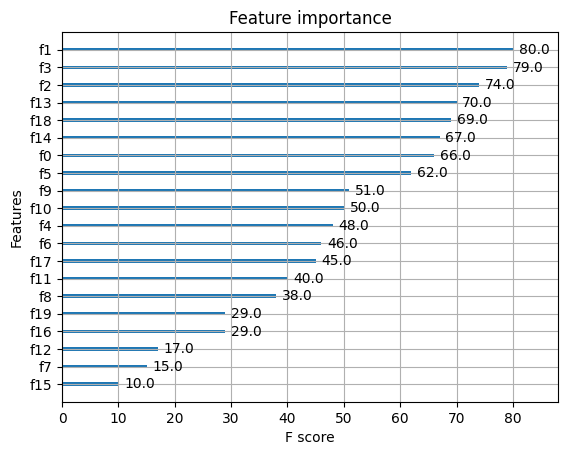

In [34]:
xgb.plot_importance(model)
plt.show() 

In [35]:
y_pred_final = best_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f'Final Model Accuracy: {accuracy_final}') 

Final Model Accuracy: 0.92
